## Classifying Heart Disease using simple neural network

#### 1. Import libraries and required packages

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

C:\Users\Excalibur\AppData\Local\Temp\ipykernel_55084\766564529.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


#### 2. Import dataset from the provided link

In [2]:
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
dataset = pd.read_csv(url, sep=',', header=None)

dataset.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']

dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


#### Information about the dataset

    Disease = 0 -> No heart disease
    Disease = 1,2,3,4 -> presence of heart disease

    Dataset contains 13 features and 303 entries/observations

#### 3. Clean the data

In [3]:
# Check for any NaNs in each column
dataset.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
DISEASE     0
dtype: int64

In [4]:
# Some observations contain '?' instead of NaNs 
dataset = dataset.replace('?', np.nan)
dataset.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
DISEASE     0
dtype: int64

In [5]:
# Remove NaNs  
dataset = dataset.dropna()

In [6]:
# Check for any duplicating values
dataset.duplicated().sum()

0

#### 4. Explore the data

In [7]:
# Check datatypes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    object 
 12  thal      297 non-null    object 
 13  DISEASE   297 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 34.8+ KB


In [8]:
# Number of unique values in each observation
dataset.nunique()

age          41
sex           2
cp            4
trestbps     50
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            4
thal          3
DISEASE       5
dtype: int64

In [9]:
# Separate the columns containing numerical values
drop_list = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df_num = dataset[drop_list]

df_cat = dataset.drop(drop_list,axis=1)
df_cat

,sex,cp,fbs,restecg,exang,slope,ca,thal,DISEASE
0,1.0,1.0,1.0,2.0,0.0,3.0,0.0,6.0,0
1,1.0,4.0,0.0,2.0,1.0,2.0,3.0,3.0,2
2,1.0,4.0,0.0,2.0,1.0,2.0,2.0,7.0,1
3,1.0,3.0,0.0,0.0,0.0,3.0,0.0,3.0,0
4,0.0,2.0,0.0,2.0,0.0,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...
297,0.0,4.0,0.0,0.0,1.0,2.0,0.0,7.0,1
298,1.0,1.0,0.0,0.0,0.0,2.0,0.0,7.0,1
299,1.0,4.0,1.0,0.0,0.0,2.0,2.0,7.0,2
300,1.0,4.0,0.0,0.0,1.0,2.0,1.0,7.0,3


In [10]:
# unique values in each feature
for feature in df_cat.columns:
    unique_values = df_cat[feature].unique()
    print(f"Unique values in {feature} : {unique_values}")

Unique values in sex : [1. 0.]
Unique values in cp : [1. 4. 3. 2.]
Unique values in fbs : [1. 0.]
Unique values in restecg : [2. 0. 1.]
Unique values in exang : [0. 1.]
Unique values in slope : [3. 2. 1.]
Unique values in ca : ['0.0' '3.0' '2.0' '1.0']
Unique values in thal : ['6.0' '3.0' '7.0']
Unique values in DISEASE : [0 2 1 3 4]


In [11]:
# summary of descriptive statistics of the numerical data
df_num.describe()

,age,trestbps,chol,thalach,oldpeak
count,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,131.693603,247.350168,149.599327,1.055556
std,9.049736,17.762806,51.997583,22.941562,1.166123
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.000000,0.000000
50%,56.000000,130.000000,243.000000,153.000000,0.800000
75%,61.000000,140.000000,276.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [12]:
#### 5. Visualize the data distributions

C:\Users\Excalibur\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Excalibur\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


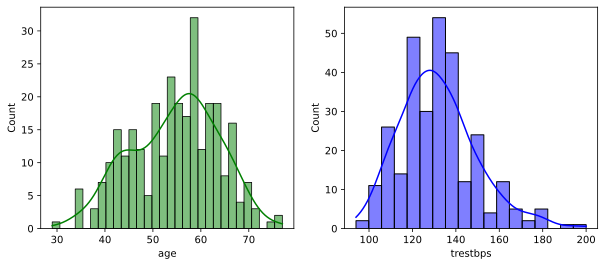

In [13]:
# Histogram
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(121)
sns.histplot(data=df_num,x='age',bins=30,kde=True,color='g')
plt.subplot(122)
sns.histplot(data=df_num,x='trestbps',kde=True,color='b')
plt.show()

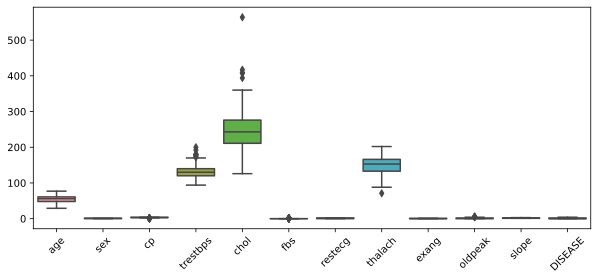

In [14]:
# Boxplots
fig,ax = plt.subplots(1,figsize=(10,4))
ax = sns.boxplot(data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

#### 6. Prepare the data for the Dataloaders

##### Z-score Formula

The Z-score is calculated as:

$$
Z = \frac{x - \mu}{\sigma}
$$
Where:
- \(x\) is the original value.
- \($\mu$) is the mean of the column.
- \($\sigma$) is the standard deviation of the column.

In [15]:
# Normalize data using z-score 

zscore = dataset.keys()
zscore = zscore.drop(['sex', 'fbs', 'exang', 'DISEASE']) #already in [0-1] range

for c in zscore:
    d = pd.to_numeric(dataset[c])
    dataset[c] = (d - d.mean())/d.std(ddof=1)

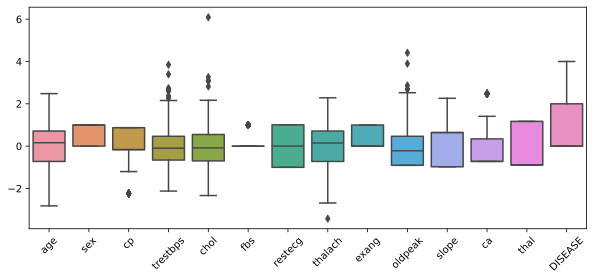

In [16]:
# check distributions again
fig,ax = plt.subplots(1,figsize=(10,4))
ax = sns.boxplot(data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [17]:
# Format the labels -> DISEASE
# 0 -> Absent
# 1 -> Present

dataset['DISEASE'][dataset['DISEASE'] > 0] = 1
dataset['DISEASE'].value_counts()

C:\Users\Excalibur\AppData\Local\Temp\ipykernel_55084\3868275394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['DISEASE'][dataset['DISEASE'] > 0] = 1


DISEASE
0    160
1    137
Name: count, dtype: int64

In [18]:
# Convert pandas dataframe to tensor
dataT = torch.tensor( dataset[dataset.keys().drop('DISEASE')].values ).float()
labels = torch.tensor( dataset['DISEASE'].values ). float()

# Convert labels into a column vector
labelT = labels[:, None] 

# Check shapes
print(dataT.shape)
print(labelT.shape)

torch.Size([297, 13])
torch.Size([297, 1])


In [19]:
# Split the data into train-test
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelT, test_size=50)

# Convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data =  TensorDataset(test_data, test_labels)

# Create dataloaders objects
batchsize = 20
train_dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

#### 7. Define model class

In [21]:
class ClassifyFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(13, 32)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 10)
        self.output = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu( self.input(x) )
        x = F.relu( self.fc1(x) )
        x = F.relu( self.fc2(x) )
        return self.output(x)

In [22]:
# Testing the model
model = ClassifyFNN()

X, y = next(iter(train_dataloader))
y_pred = model(X)
print(y_pred)

lossfun = nn.BCEWithLogitsLoss()
lossfun(y_pred,y)

tensor([[0.0977],
        [0.1014],
        [0.0912],
        [0.1052],
        [0.0734],
        [0.0799],
        [0.0699],
        [0.1060],
        [0.1088],
        [0.0841],
        [0.1185],
        [0.1080],
        [0.0982],
        [0.1085],
        [0.0886],
        [0.0765],
        [0.1098],
        [0.1013],
        [0.1004],
        [0.0966]], grad_fn=<AddmmBackward0>)


tensor(0.6902, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

#### 8. Create the training pipeline

In [23]:
model = ClassifyFNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
lossfun = nn.BCEWithLogitsLoss()
numepochs = 100

# Initialize lists to track progress
trainAcc  = torch.zeros(numepochs)
trainLoss = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)

for epochi in range(numepochs):

    batchLoss = []
    for X, y in train_dataloader:

        # forward pass
        y_pred = model(X)
        loss = lossfun(y_pred, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())

        #train accuracy
        predictions = (torch.sigmoid(y_pred)>0.5).float() # converts boolean to [0-1]
        trainAcc[epochi] = 100*torch.mean((predictions == y).float()) # mean of predictions for batch

    trainLoss[epochi] = np.mean(batchLoss)

    X, y = next(iter(test_dataloader))
    
    y_pred = model(X)
    loss = lossfun(y_pred, y)

    testLoss[epochi] = loss.item()

    predictions = (torch.sigmoid(y_pred)>0.5).float()
    testAcc[epochi] = 100*torch.mean((predictions == y).float())        

#### 9. Plot and evaluate model performance

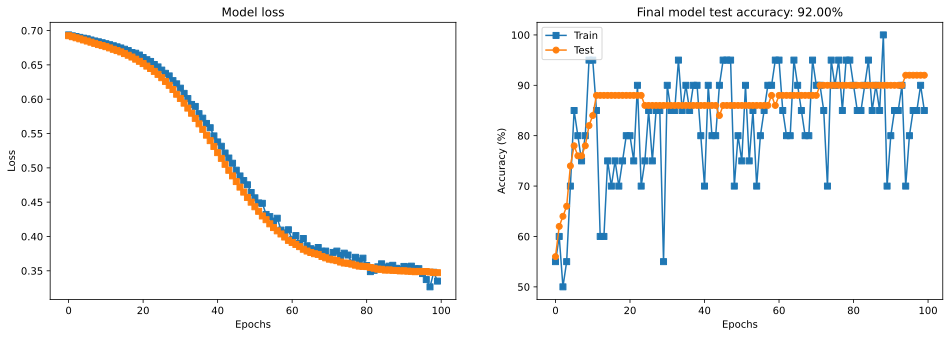

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'s-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [25]:
# Plot